The following code is a maximum likelihood estimation implementation of ICA, as discussed in the notes.

In [1]:
import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
np.random.seed(23)

# Number of samples
ns = np.linspace(0, 200, 1000)
S = np.array([np.sin(ns * 1),
              signal.sawtooth(ns * 1.9),
              np.random.random(len(ns))]).T
A = np.array([[0.5, 1, 0.2],
              [1, 0.5, 0.4],
              [0.5, 0.8, 1]])


X = S.dot(A).T

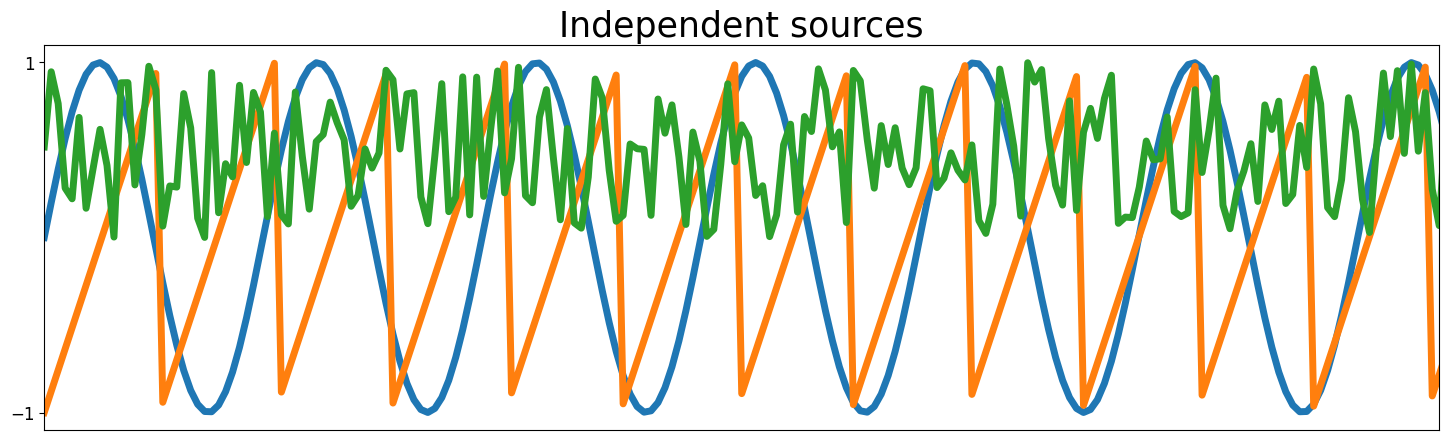

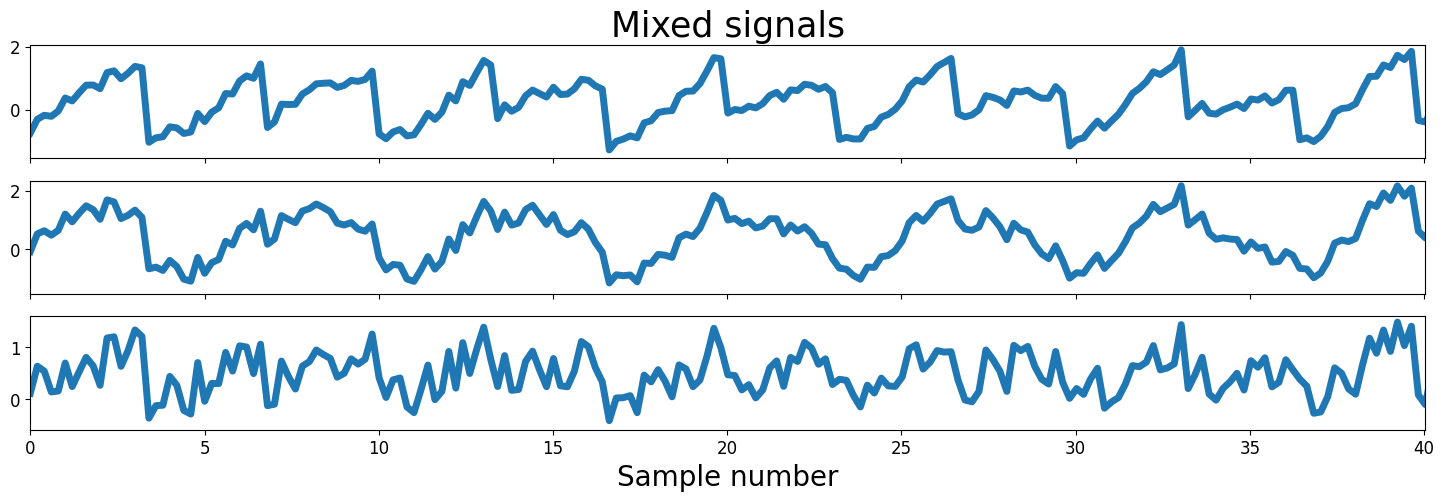

In [3]:
fig, ax = plt.subplots(1, 1, figsize=[18, 5])
ax.plot(ns, S, lw=5)
ax.set_xticks([])
ax.set_yticks([-1, 1])
ax.set_xlim(ns[0], ns[200])
ax.tick_params(labelsize=12)
ax.set_title('Independent sources', fontsize=25)

fig, ax = plt.subplots(3, 1, figsize=[18, 5], sharex=True)
ax[0].plot(ns, X[0], lw=5)
ax[0].set_title('Mixed signals', fontsize=25)
ax[0].tick_params(labelsize=12)

ax[1].plot(ns, X[1], lw=5)
ax[1].tick_params(labelsize=12)
ax[1].set_xlim(ns[0], ns[-1])

ax[2].plot(ns, X[2], lw=5)
ax[2].tick_params(labelsize=12)
ax[2].set_xlim(ns[0], ns[-1])
ax[2].set_xlabel('Sample number', fontsize=20)
ax[2].set_xlim(ns[0], ns[200])

plt.show()

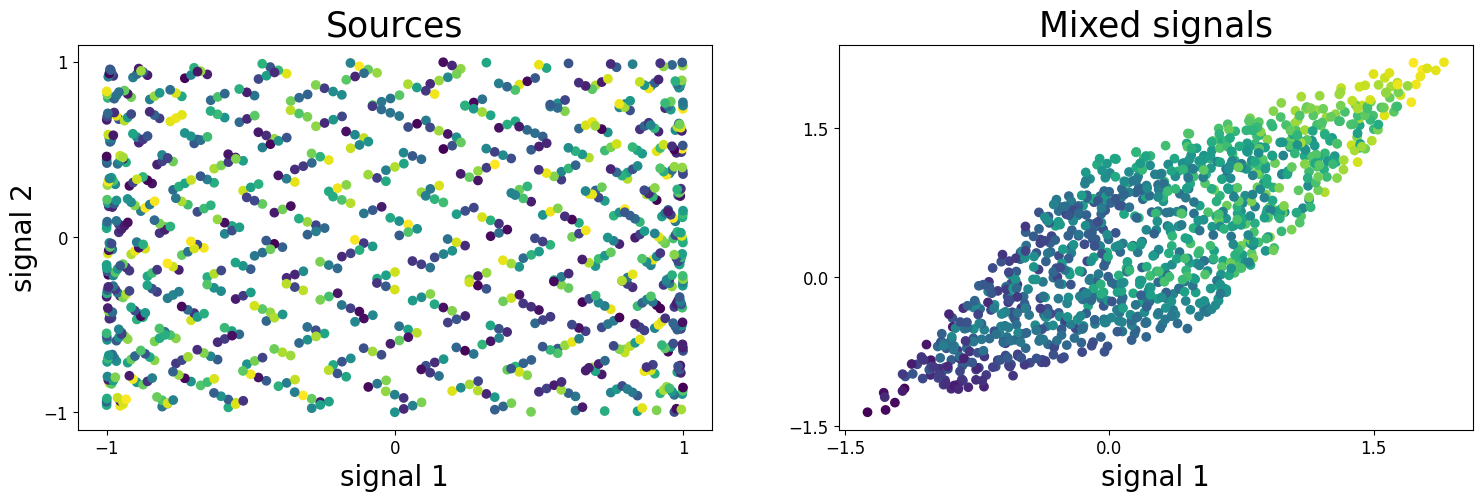

In [4]:
fig, ax = plt.subplots(1, 2, figsize=[18, 5])
ax[0].scatter(S.T[0], S.T[1], c=S.T[2])
ax[0].tick_params(labelsize=12)
ax[0].set_yticks([-1, 0, 1])
ax[0].set_xticks([-1, 0, 1])
ax[0].set_xlabel('signal 1', fontsize=20)
ax[0].set_ylabel('signal 2', fontsize=20)
ax[0].set_title('Sources', fontsize=25)

ax[1].scatter(X[0], X[1], c=X[2])
ax[1].tick_params(labelsize=12)
ax[1].set_yticks([-1.5, 0, 1.5])
ax[1].set_xticks([-1.5, 0, 1.5])
ax[1].set_xlabel('signal 1', fontsize=20)
ax[1].set_title('Mixed signals', fontsize=25)
plt.show()

In [5]:
def center(x):
    mean = np.mean(x, axis=1, keepdims=True)
    centered =  x - mean
    return centered, mean

In [6]:
def covar(x):
    m, mean = center(x)
    n = np.shape(x)[1]-1
    return m.dot(m.T)/n

In [7]:
def whiten(x):
    covar_matrix = covar(x)
    U, S, V = np.linalg.svd(covar_matrix)
    d = np.diag(1.0 / np.sqrt(S))
    white_matrix= np.dot(U, np.dot(d, U.T))
    Xw = np.dot(white_matrix, X)
    return Xw, white_matrix

In [8]:
def sigmoid(x):
    """
    Applies the sigmoid function to an input.

    Args:
        x: A scalar, NumPy array, or any other object that numpy.exp can handle.

    Returns:
        The sigmoid of x.
    """
    return 1 / (1 + np.exp(-x))

In [9]:
def ICA(signals,  alpha = 0.01, thresh=1e-8, iterations=2000):
    m, n = signals.shape
    W = np.random.rand(m, m)
    for c in range(m):
        # Initialize 1D weight vector
        w = W[c, :].copy()
        w = w / np.sqrt(np.sum(w ** 2))

        i = 0
        lim = 100

        while lim > thresh and i < iterations:
            ws = np.dot(w, signals)
            grad = np.dot((1 - 2 * sigmoid(ws)), signals.T) / n
            wNew = w + alpha * grad
            if c > 0:
                proj = np.dot(wNew, W[:c].T)
                wNew = wNew - np.dot(proj, W[:c])
            wNew = wNew / np.sqrt(np.sum(wNew ** 2))
            lim = np.abs(np.abs(np.dot(wNew, w)) - 1)
            w = wNew
            i += 1
        W[c, :] = w
    return W

In [10]:
Xc, meanX = center(X)

In [11]:
Xw, whiteM = whiten(Xc)

In [12]:
print(np.round(covar(Xw)))

[[ 1.  0. -0.]
 [ 0.  1. -0.]
 [-0. -0.  1.]]


In [13]:
W = ICA(Xw)
unmixed = Xw.T.dot(W.T)
unmixed = (unmixed.T - meanX).T

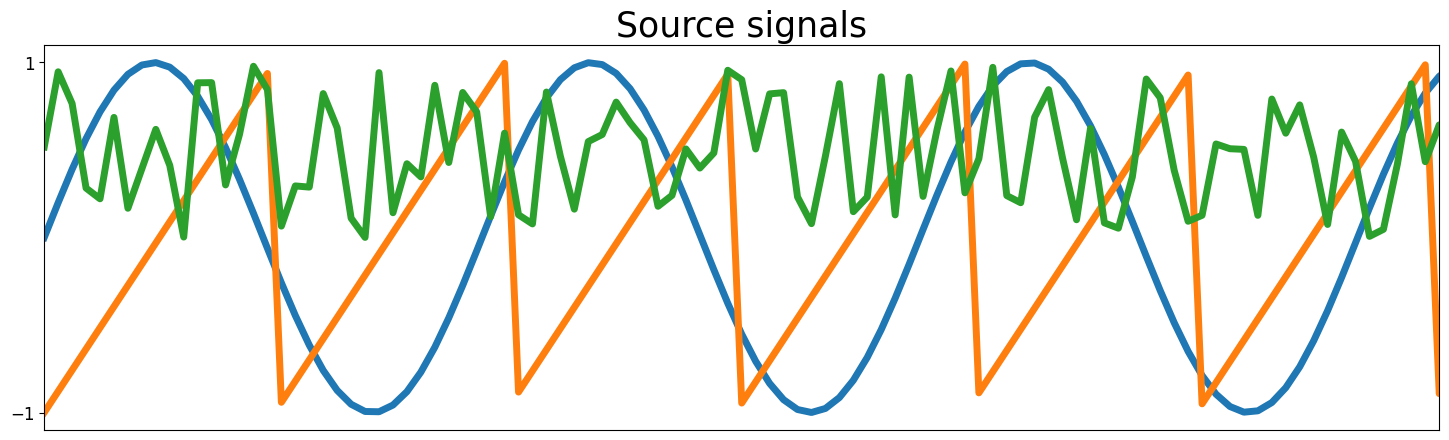

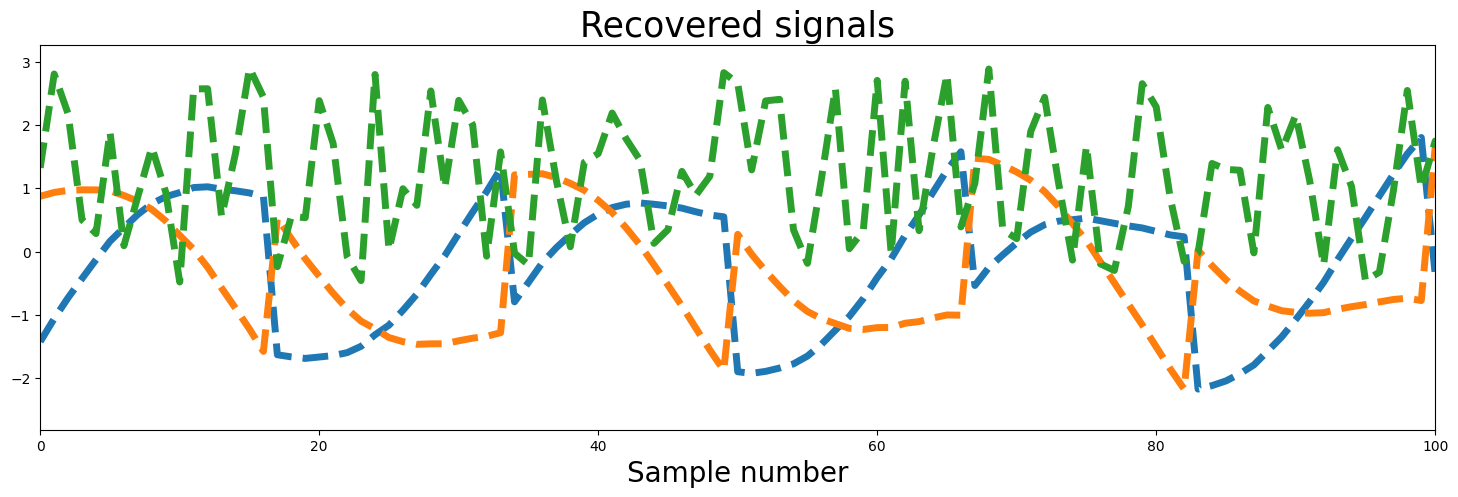

In [14]:
fig, ax = plt.subplots(1, 1, figsize=[18, 5])
ax.plot(S, lw=5)
ax.tick_params(labelsize=12)
ax.set_xticks([])
ax.set_yticks([-1, 1])
ax.set_title('Source signals', fontsize=25)
ax.set_xlim(0, 100)

fig, ax = plt.subplots(1, 1, figsize=[18, 5])
ax.plot(unmixed, '--', label='Recovered signals', lw=5)
ax.set_xlabel('Sample number', fontsize=20)
ax.set_title('Recovered signals', fontsize=25)
ax.set_xlim(0, 100)

plt.show()